In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('../runtime/benchmark_dump.txt', sep=' ')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  marker      time  dt_micro  device_timestamp  current0  voltage0    power0  \
0      S  0.029371     29370               982  0.575216   20.1658  11.59970   
1      S  0.030970      1599                 8  0.440807   20.1658   8.88924   
2      S  0.031012        43                59  0.521451   20.1658  10.51550   
3      S  0.031044        30               108  0.440807   20.1658   8.88924   
4      S  0.031074        30               159  0.467688   20.1658   9.43131   

   power_total  
0     11.59970  
1      8.88924  
2     10.51550  
3      8.88924  
4      9.43131  


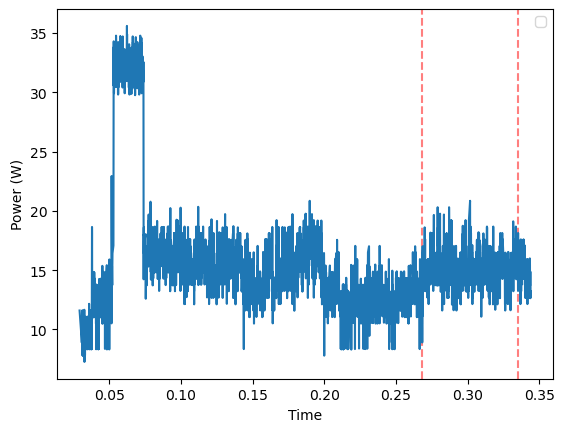

In [38]:
# print(df.head())

samples = df[df['marker'] == 'S']
markers = df[df['marker'] != 'S']

plt.xlabel('Time')
plt.ylabel('Power (W)')

print(df.head())

# Plot the markers
for _, m in markers.iterrows():
    plt.axvline(x=m['time'], color='red', linestyle='--', alpha=0.5)

plt.plot(samples['time'], samples['power0'])

plt.legend()